# Topological regularization of bifurcating cell trajectory embedding

In this notebook, we show how a topological loss can be combined with a non-linear embedding procedure, as to regularize the embedding and better reflect the topological---in this case bifurcating---prior.

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Loading R objects into python
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri 

# Pytorch compatible topology layer and losses
import torch
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss, umap_loss

# Ordinary and topologically regularized UMAP embedding
from Code.topembed import UMAP
UMAP(np.array(np.random.rand(30, 5)), num_epochs=0) # Execute once for numba code compilation

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Quantitative evaluation
from sklearn.svm import SVC
from Code.evaluation import evaluate_embeddings

%matplotlib inline

## Load data and view ordinary UMAP embedding

We start by loading the data and visualize it by means of its ordinary UMAP embedding.

Data shape: (154, 1770)
[epoch 1] [emb. loss: 9376.855727, top. loss: 0.000000, total loss: 9376.855727]
[epoch 10] [emb. loss: 9103.008830, top. loss: 0.000000, total loss: 9103.008830]
[epoch 20] [emb. loss: 8850.547525, top. loss: 0.000000, total loss: 8850.547525]
[epoch 30] [emb. loss: 8824.020165, top. loss: 0.000000, total loss: 8824.020165]
[epoch 40] [emb. loss: 8703.961411, top. loss: 0.000000, total loss: 8703.961411]
[epoch 50] [emb. loss: 8450.941803, top. loss: 0.000000, total loss: 8450.941803]
[epoch 60] [emb. loss: 8749.852056, top. loss: 0.000000, total loss: 8749.852056]
[epoch 70] [emb. loss: 8618.780763, top. loss: 0.000000, total loss: 8618.780763]
[epoch 80] [emb. loss: 8421.186200, top. loss: 0.000000, total loss: 8421.186200]
[epoch 90] [emb. loss: 8466.879089, top. loss: 0.000000, total loss: 8466.879089]
[epoch 100] [emb. loss: 8419.206423, top. loss: 0.000000, total loss: 8419.206423]
Time for embedding: 00:00:00


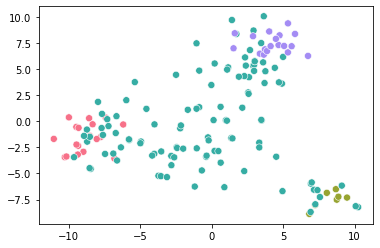

In [2]:
# Load the data
file_name = os.path.join("Data", "CellBifurcating.rds")
cell_info = ro.r["readRDS"](file_name)
cell_info = dict(zip(cell_info.names, list(cell_info)))

pandas2ri.activate()
data = ro.conversion.rpy2py(cell_info["expression"])
t = list(ro.conversion.rpy2py(cell_info["cell_info"])
         .rename(columns={"milestone_id": "group_id"}).loc[:,"group_id"])
pandas2ri.deactivate()

print("Data shape: " + str(data.shape))

# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-1

# Conduct ordinary UMAP embedding
Y_umap, losses_umap = UMAP(data, num_epochs=num_epochs, learning_rate=learning_rate, random_state=42)

# View the data through its UMAP embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_umap[:,0], y=Y_umap[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

## Apply topological regularization to the embedding

We now show how we can bias a non-linear embedding using a loss function that captures our topological prior. This topological loss will be a linear combination of two separate losses:
- $\lambda_{\mathrm{flare}} <0$: A topological loss that encourages three clusters away from our embedding mean. It is proportional to the sum of persistence of the three most persisting components (neglecting the one with infinite persistence) in the fraction of our embedding that is sufficiently far from the embedding mean according to a proportional threshold $\tau_{\mathrm{flare}}$ fixed in advance.
- $\lambda_{\mathrm{connected}} >0$: A topological loss that encourages our embedded model to remain connected.

To obtain these losses, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [3]:
# Define topological optimization
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
ComponentPersistence = DiagramLoss(dim=0, i=2, g=g) # compute total (finite) persistence
Component3Persistence = DiagramLoss(dim=0, i=3, j=3, g=g) # compute persistence of third most prominent gap
lambda_top = 1e1 # scalar factor that trades off embedding and topological loss
tau_flare = 0.25 # sample fraction for which the flare topological loss is computed

# Construct topological loss function
def top_loss(output):    
    # Loss for connectedness
    dgminfo_connected = TopLayer(output)         
    loss_connected = ComponentPersistence(dgminfo_connected)

    # Loss for flare
    f = torch.norm(output - torch.mean(output, dim=0), dim=1)
    f /= torch.max(f)
    dgminfo_flare = TopLayer(output[f > tau_flare,:])
    loss_flare = -Component3Persistence(dgminfo_flare)    
        
    # Total loss
    loss = lambda_top * (loss_connected + loss_flare)
    
    return loss

We can now conduct the topologically regularized embedding as follows.

[epoch 1] [emb. loss: 9376.855727, top. loss: 1412.720459, total loss: 10789.576186]
[epoch 10] [emb. loss: 9424.549514, top. loss: 967.172241, total loss: 10391.721755]
[epoch 20] [emb. loss: 9237.509794, top. loss: 804.668701, total loss: 10042.178495]
[epoch 30] [emb. loss: 9163.613059, top. loss: 710.923767, total loss: 9874.536827]
[epoch 40] [emb. loss: 9133.507288, top. loss: 658.947815, total loss: 9792.455103]
[epoch 50] [emb. loss: 9239.509584, top. loss: 652.785522, total loss: 9892.295106]
[epoch 60] [emb. loss: 9136.785422, top. loss: 643.777466, total loss: 9780.562888]
[epoch 70] [emb. loss: 9038.252752, top. loss: 629.470581, total loss: 9667.723333]
[epoch 80] [emb. loss: 8974.596282, top. loss: 643.432922, total loss: 9618.029205]
[epoch 90] [emb. loss: 9085.446099, top. loss: 623.973328, total loss: 9709.419426]
[epoch 100] [emb. loss: 8981.926104, top. loss: 630.493286, total loss: 9612.419390]
Time for embedding: 00:00:08


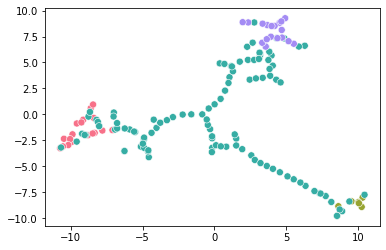

In [4]:
# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-1

# Conduct topological regularization
Y_top, losses_top = UMAP(data, top_loss=top_loss, num_epochs=num_epochs, 
                         learning_rate=learning_rate, random_state=42)

# View topologically regularized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_top[:,0], y=Y_top[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

## Compare with ordinary topological optimization

For comparison, we also conduct the same topological optimization procedure directly on the initialized embedding.

[epoch 1] [emb. loss: 0.000000, top. loss: 1167.495728, total loss: 1167.495728]
[epoch 10] [emb. loss: 0.000000, top. loss: 723.169067, total loss: 723.169067]
[epoch 20] [emb. loss: 0.000000, top. loss: 539.727295, total loss: 539.727295]
[epoch 30] [emb. loss: 0.000000, top. loss: 429.159058, total loss: 429.159058]
[epoch 40] [emb. loss: 0.000000, top. loss: 364.528503, total loss: 364.528503]
[epoch 50] [emb. loss: 0.000000, top. loss: 320.426392, total loss: 320.426392]
[epoch 60] [emb. loss: 0.000000, top. loss: 288.649963, total loss: 288.649963]
[epoch 70] [emb. loss: 0.000000, top. loss: 267.297821, total loss: 267.297821]
[epoch 80] [emb. loss: 0.000000, top. loss: 252.922058, total loss: 252.922058]
[epoch 90] [emb. loss: 0.000000, top. loss: 242.767914, total loss: 242.767914]
[epoch 100] [emb. loss: 0.000000, top. loss: 233.778214, total loss: 233.778214]
Time for embedding: 00:00:08


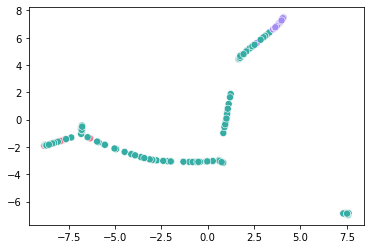

In [5]:
# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-1

# Conduct topological optimization (UMAP)
Y_opt, losses_opt = UMAP(Y_umap, emb_loss=False, top_loss=top_loss, num_epochs=num_epochs, 
                         learning_rate=learning_rate, random_state=42)

# View topologically optimized embedding (UMAP)
fig, ax = plt.subplots()
sns.scatterplot(x=Y_opt[:,0], y=Y_opt[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

We observe that without the embedding loss, the represented topologies are more fragmented and more interior points representing the bifurcation are pulled towards the ends.

## Quantitative evaluation

First, we evaluate the different losses (embedding and topological) for all final embeddings.

In [6]:
print("\033[1mLosses for umap embedding: \033[0m")
print("Embedding: " + str(umap_loss(losses_umap["P"], torch.tensor(Y_umap).type(torch.float), 
                                    losses_umap["a"], losses_umap["b"]).item()))
print("Topological: " + str(top_loss(torch.tensor(Y_umap).type(torch.float)).item() / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically optimized umap embedding: \033[0m")
print("Embedding: " + str(umap_loss(losses_opt["P"], torch.tensor(Y_opt).type(torch.float), 
                                    losses_opt["a"], losses_opt["b"]).item()))
print("Topological: " + str(top_loss(torch.tensor(Y_opt).type(torch.float)).item() / 
                            np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically regularized umap embedding: \033[0m")
print("Embedding: " + str(umap_loss(losses_top["P"], torch.tensor(Y_top).type(torch.float), 
                                    losses_top["a"], losses_top["b"]).item()))
print("Topological: " + str(top_loss(torch.tensor(Y_top).type(torch.float)).item() / np.abs(lambda_top)))

Losses for umap embedding: 
Embedding: 8576.364944816134
Topological: 116.74957275390625

Losses for topologically optimized umap embedding: 
Embedding: 9932.898996191445
Topological: 23.302349853515626

Losses for topologically regularized umap embedding: 
Embedding: 8871.473401997777
Topological: 62.9324462890625


Finally, we compare if the topologically regularized embedding improves on the ordinary UMAP embedding for predicting data point labels.

In [7]:
# Machine learning model to be used for label prediction
Ys = {"umap": Y_umap, "top. opt.": Y_opt, "top. reg.": Y_top}
model = SVC()
scoring = "accuracy"

# Hyperparameters for quantitative evaluation
ntimes = 100
test_frac = 0.1
params = {"C":[0.01, 0.1, 1, 10, 100]}

# Obtain performances over multiple train-test splits
performances = evaluate_embeddings(Ys, t, model, scoring, params=params, stratify=t,
                                   ntimes=ntimes, test_frac=test_frac, random_state=42)

# View resulting performances
pd.concat([pd.DataFrame({"mean":performances.mean(axis=0)}),
           pd.DataFrame({"std":performances.std(axis=0)})], axis=1)\
            .style.highlight_max(subset="mean", color="lightgreen", axis=0)

,mean,std
umap,0.787500,0.077951
top. opt.,0.811875,0.070786
top. reg.,0.820625,0.080763


## Topological regularization for different powers of the persistence lifetime
Different powers of the persistence may result in different behavior of the topological regularization. We explore this (keeping all other hyperparameters identical) as follows.

Conducting topologically regularized embedding for lifetime power 0.5
[epoch 1] [emb. loss: 9376.855727, top. loss: 1400.352173, total loss: 10777.207900]
[epoch 10] [emb. loss: 9150.710593, top. loss: 1202.514771, total loss: 10353.225364]
[epoch 20] [emb. loss: 9151.445905, top. loss: 1126.345215, total loss: 10277.791120]
[epoch 30] [emb. loss: 9055.769724, top. loss: 1076.250000, total loss: 10132.019724]
[epoch 40] [emb. loss: 8940.097309, top. loss: 1046.674316, total loss: 9986.771625]
[epoch 50] [emb. loss: 8987.077069, top. loss: 1028.369385, total loss: 10015.446454]
[epoch 60] [emb. loss: 8903.144402, top. loss: 1028.905396, total loss: 9932.049798]
[epoch 70] [emb. loss: 8937.635326, top. loss: 1003.204895, total loss: 9940.840221]
[epoch 80] [emb. loss: 8786.045473, top. loss: 1004.524902, total loss: 9790.570375]
[epoch 90] [emb. loss: 8853.924331, top. loss: 984.087219, total loss: 9838.011550]
[epoch 100] [emb. loss: 8987.524060, top. loss: 987.737366, total loss: 9975.

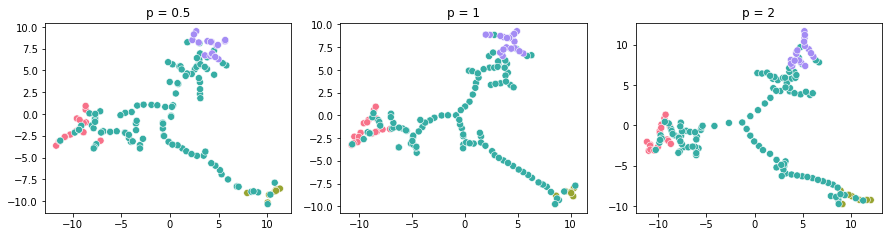

In [8]:
# Learning hyperparameters
num_epochs = 100
learning_rate = 1e-1

# Conduct topological regularization for different powers of the persistence lifetime
powers = [1 / 2, 1, 2] # p = 1 equals or previous case, which we include for easy comparison
Y_tops = []

for idx, p in enumerate(powers):
    # Construct topological loss function
    def gp(d): return (d[1] - d[0])**p # returns the p-th power of the persistence d - b of a point (b, d)
    pComponentPersistence = DiagramLoss(dim=0, i=2, g=gp) # for low total (finite) persistence
    pComponent3Persistence = DiagramLoss(dim=0, i=3, j=3, g=gp) # for high persistence of third most prominent gap
    def p_top_loss(output):    
        # Loss for connectedness
        dgminfo_connected = TopLayer(output)         
        loss_connected = pComponentPersistence(dgminfo_connected)

        # Loss for flare
        f = torch.norm(output - torch.mean(output, dim=0), dim=1)
        f /= torch.max(f)
        dgminfo_flare = TopLayer(output[f > tau_flare,:])
        loss_flare = -pComponent3Persistence(dgminfo_flare)

        # Total loss
        loss = lambda_top * (loss_connected + loss_flare)

        return loss

    # Conduct topological regularization
    print("\033[1mConducting topologically regularized embedding for lifetime power " + str(p) + "\033[0m")
    this_Y_top, losses_top = UMAP(data, top_loss=p_top_loss, num_epochs=num_epochs, 
                                  learning_rate=learning_rate, random_state=42)
    Y_tops.append(this_Y_top)
    print("\n")
    
# View topologically regularized embeddings for different persistence lifetime powers
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
for idx, p in enumerate(powers):
    sns.scatterplot(x=Y_tops[idx][:,0], y=Y_tops[idx][:,1], s=50, hue=t, palette="husl", ax=ax[idx])
    ax[idx].get_legend().remove()
    ax[idx].set_title("p = " + str(p))
plt.show()

We observe that the topological regularization is reasonably stable against the choice of the power of the persistence lifetime.

## Topological regularization for different shape prior
Finally, we study how the tologically regularized embedding varies for a different potentially wrong prior. In particular, we study the topologically regularized embedding when the topological loss function is designed to ensure that the persistence of the most prominent cycle is high. All other hyperparameters will be kept equal.

In [19]:
# Define different topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
CircularPersistence = DiagramLoss(dim=1, j=1, g=g) # compute persistence of most prominent cycle
lambda_top = 1e1 # scalar factor that trades off embedding and topological loss

# Construct the topological loss functions
def top_loss_other(output):
    dgminfo = TopLayer(output)
    loss = -lambda_top * (CircularPersistence(dgminfo))
    
    return loss

We explore the topologically regularized embedding for multiple epochs.

Conducting topologically regularized embedding for 100 epochs
[epoch 1] [emb. loss: 9376.855727, top. loss: -15.400949, total loss: 9361.454778]
[epoch 10] [emb. loss: 9039.074319, top. loss: -26.457535, total loss: 9012.616785]
[epoch 20] [emb. loss: 8869.637188, top. loss: -33.650097, total loss: 8835.987091]
[epoch 30] [emb. loss: 8756.361980, top. loss: -37.516628, total loss: 8718.845352]
[epoch 40] [emb. loss: 8618.454895, top. loss: -39.182213, total loss: 8579.272682]
[epoch 50] [emb. loss: 8743.236561, top. loss: -44.038883, total loss: 8699.197678]
[epoch 60] [emb. loss: 8721.251276, top. loss: -38.449944, total loss: 8682.801333]
[epoch 70] [emb. loss: 8716.132112, top. loss: -43.078751, total loss: 8673.053362]
[epoch 80] [emb. loss: 8541.475153, top. loss: -41.121223, total loss: 8500.353930]
[epoch 90] [emb. loss: 8631.374361, top. loss: -40.123985, total loss: 8591.250375]
[epoch 100] [emb. loss: 8543.023783, top. loss: -37.061806, total loss: 8505.961977]
Time for embed

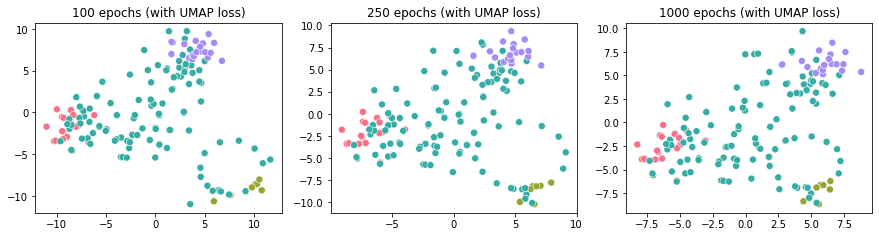

In [21]:
# Learning hyperparameters
num_epochs = [100, 250, 1000]
learning_rate = 1e-1

# Conduct topological regularization for multiple number of epochs
Y_epochs = {}
for epochs in num_epochs:
    print("\033[1mConducting topologically regularized embedding for " + str(epochs) + " epochs\033[0m")
    Y_epochs[epochs], losses_top_other = UMAP(data, top_loss=top_loss_other, num_epochs=epochs, 
                                              learning_rate=learning_rate, random_state=42)
    print("\n")
    
# View topologically regularized embeddings
fig, ax = plt.subplots(1, len(num_epochs), figsize=(len(num_epochs) * 5, 3.5))
for idx, epochs in enumerate(num_epochs):
    sns.scatterplot(x=Y_epochs[epochs][:,0], y=Y_epochs[epochs][:,1], s=50, hue=t, palette="husl", ax=ax[idx])
    ax[idx].get_legend().remove()
    ax[idx].set_title(str(epochs) + " epochs (with UMAP loss)")
plt.show()

We observe that the cycle struggles to enlarge for higher number of epochs. The fact that this is due to the inclusion of the UMAP loss, can be confirmed by conducting the same topological optimization without the UMAP loss.

Conducting topologically optimization for 100 epochs
[epoch 1] [emb. loss: 0.000000, top. loss: -8.952889, total loss: -8.952889]
[epoch 10] [emb. loss: 0.000000, top. loss: -29.148804, total loss: -29.148804]
[epoch 20] [emb. loss: 0.000000, top. loss: -36.754570, total loss: -36.754570]
[epoch 30] [emb. loss: 0.000000, top. loss: -47.674465, total loss: -47.674465]
[epoch 40] [emb. loss: 0.000000, top. loss: -55.700363, total loss: -55.700363]
[epoch 50] [emb. loss: 0.000000, top. loss: -63.632767, total loss: -63.632767]
[epoch 60] [emb. loss: 0.000000, top. loss: -72.809006, total loss: -72.809006]
[epoch 70] [emb. loss: 0.000000, top. loss: -78.857086, total loss: -78.857086]
[epoch 80] [emb. loss: 0.000000, top. loss: -83.158836, total loss: -83.158836]
[epoch 90] [emb. loss: 0.000000, top. loss: -88.401649, total loss: -88.401649]
[epoch 100] [emb. loss: 0.000000, top. loss: -91.513374, total loss: -91.513374]
Time for embedding: 00:00:03


Conducting topologically optimization 

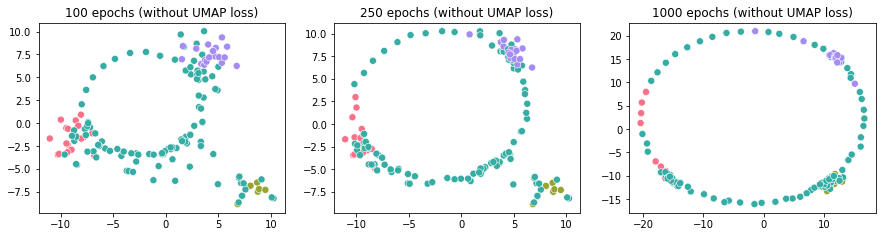

In [22]:
# Learning hyperparameters
num_epochs = [100, 250, 1000]
learning_rate = 1e-1

# Conduct topological optimization for multiple number of epochs
Y_opt_epochs = {}
for epochs in num_epochs:
    print("\033[1mConducting topologically optimization for " + str(epochs) + " epochs\033[0m")
    Y_opt_epochs[epochs], losses_opt_other = UMAP(Y_umap, emb_loss=False, top_loss=top_loss_other, 
                                                  num_epochs=epochs, learning_rate=learning_rate, random_state=42)
    print("\n")
    
# View topologically optimized embeddings
fig, ax = plt.subplots(1, len(num_epochs), figsize=(len(num_epochs) * 5, 3.5))
for idx, epochs in enumerate(num_epochs):
    sns.scatterplot(x=Y_opt_epochs[epochs][:,0], y=Y_opt_epochs[epochs][:,1], 
                    s=50, hue=t, palette="husl", ax=ax[idx])
    ax[idx].get_legend().remove()
    ax[idx].set_title(str(epochs) + " epochs (without UMAP loss)")
plt.show()

Finally, the evolution of the loss functions according to the number of epochs can be plotted as follows.

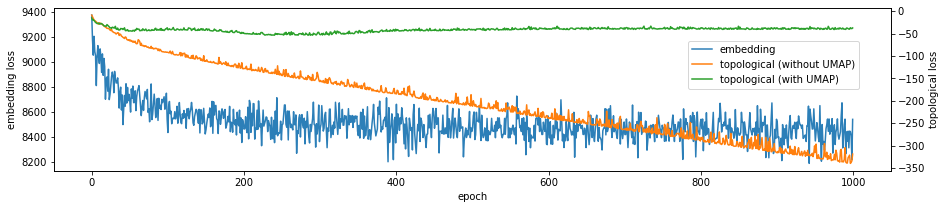

In [23]:
# Summarize the topological and embedding losses in a data frame 
pd_losses_other = pd.DataFrame({"epoch":range(losses_top_other["losses"].shape[0]),
                                "embedding":losses_top_other["losses"]["embedding"],
                                "topological (with UMAP)":losses_top_other["losses"]["topological"],
                                "topological (without UMAP)":losses_opt_other["losses"]["topological"]})

# Plot the losses according to the number of epochs
ax = pd_losses_other.plot(x="epoch", y="embedding", legend=False, figsize=(15, 3), color="#2c7fb8")
ax.set_ylabel("embedding loss")
ax2 = ax.twinx()
pd_losses_other.plot(x="epoch", y="topological (without UMAP)", legend=False, color="#ff7f0e", ax=ax2)
pd_losses_other.plot(x="epoch", y="topological (with UMAP)", legend=False, color="#2ca02c", ax=ax2)
ax2.set_ylabel("topological loss")
ax.figure.legend(bbox_to_anchor=(0.875, 0.75))
plt.show()

Naturally, by increase the topological regularization strenght, representations of false topological models may still be obtained. We will explore how this can be suggested from the data as follows.

Conducting topologically regularized embedding for 100 epochs
[epoch 1] [emb. loss: 9376.855727, top. loss: -1540.094849, total loss: 7836.760878]
[epoch 10] [emb. loss: 8837.800963, top. loss: -2684.044189, total loss: 6153.756774]
[epoch 20] [emb. loss: 8909.178931, top. loss: -4385.430176, total loss: 4523.748755]
[epoch 30] [emb. loss: 8827.191133, top. loss: -4619.253418, total loss: 4207.937715]
[epoch 40] [emb. loss: 8807.578200, top. loss: -5911.369141, total loss: 2896.209059]
[epoch 50] [emb. loss: 8730.052171, top. loss: -5853.494629, total loss: 2876.557542]
[epoch 60] [emb. loss: 8640.722476, top. loss: -6445.788574, total loss: 2194.933902]
[epoch 70] [emb. loss: 8732.647312, top. loss: -7025.093262, total loss: 1707.554050]
[epoch 80] [emb. loss: 8759.913649, top. loss: -7476.041992, total loss: 1283.871657]
[epoch 90] [emb. loss: 8623.316337, top. loss: -7990.672852, total loss: 632.643485]
[epoch 100] [emb. loss: 8695.006744, top. loss: -9079.441406, total loss: -384.4

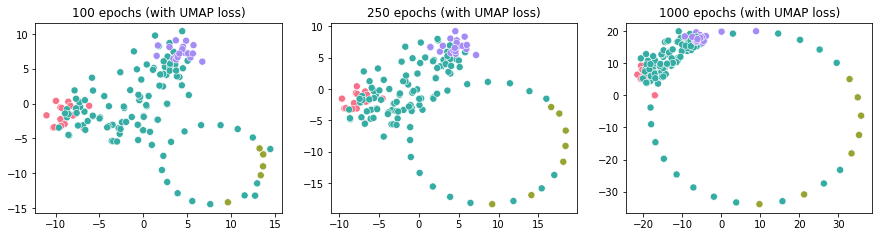

In [24]:
# Topological loss function with stronger regularization
lambda_top_multiplier = 100
def new_lambda_top_loss(output): return lambda_top_multiplier * top_loss_other(output)

# Learning hyperparameters
num_epochs = [100, 250, 1000]
learning_rate = 1e-1

# Conduct topological regularization for different topological loss function
Y_epochs_lambda = {}
for epochs in num_epochs:
    print("\033[1mConducting topologically regularized embedding for " + str(epochs) + " epochs\033[0m")
    Y_epochs_lambda[epochs], losses_lambda_other = UMAP(data, top_loss=new_lambda_top_loss, num_epochs=epochs, 
                                                        learning_rate=learning_rate, random_state=42)
    print("\n")
    
# View topologically regularized embeddings
fig, ax = plt.subplots(1, len(num_epochs), figsize=(len(num_epochs) * 5, 3.5))
for idx, epochs in enumerate(num_epochs):
    sns.scatterplot(x=Y_epochs_lambda[epochs][:,0], y=Y_epochs_lambda[epochs][:,1], 
                    s=50, hue=t, palette="husl", ax=ax[idx])
    ax[idx].get_legend().remove()
    ax[idx].set_title(str(epochs) + " epochs (with UMAP loss)")
plt.show()

We see that the cycle becomes an unnatural representation of the data, as most points remain clustered together.